In [1]:
import os
import csv
from typing import List, Tuple, Dict, Any

import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset, RandomSampler
from torchvision import transforms


import cv2
import matplotlib.pyplot as plt

from utils.losses import ArcFace
from backbones.iresnet import iresnet50

from tqdm import tqdm
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
CHECKPOINTS_PATH_FORMAT = '../checkpoints/{}backbone.pth' # 479 steps per epoch
CASIA_NUM_CLASSES = 10572
NUM_CLASSES = 10
NUM_SAMPLES_PER_CLASS = 10

In [18]:
def get_file_count(directory):
    file_count = 0
    for dirpath, dirnames, filenames in os.walk(directory):
        file_count += len(filenames)
    return file_count

def sort_directories_by_file_count(base_path):
    directories = [
        d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))
    ]
    directories_file_counts = [
        (d, get_file_count(os.path.join(base_path, d))) for d in directories
    ]
    directories_file_counts.sort(key=lambda x: x[1], reverse=True)
    return directories_file_counts

class CasiaWebFace(Dataset):
    def __init__(self, root_dir, local_rank, num_classes=10572, num_samples=None, selective=False):
        super(CasiaWebFace, self).__init__()
        self.transform = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            ]
        )
        self.root_dir = root_dir
        self.local_rank = local_rank
        self.imgidx, self.labels = self.scan(root_dir, num_classes, num_samples, selective)
        self.imageindex = np.array(range(len(self.imgidx)))

    def scan(self, root, num_classes, num_samples, selective):
        imgidex = []
        labels = []
        lb = -1
        list_dir = os.listdir(root)
        list_dir.sort()

        current_num_classes = 0

        if selective:
            directories = sort_directories_by_file_count(root)
        else:
            directories = [(l, len(os.listdir(os.path.join(root, l)))) for l in list_dir]

        for l, file_count in directories:
            if num_classes is not None and current_num_classes >= num_classes:
                break
            
            images = os.listdir(os.path.join(root, l))
            if len(images) < num_samples:
                # Skip classes with fewer than 500 images
                continue

            lb += 1
            for idx, img in enumerate(images):
                if idx >= num_samples:
                    break
                imgidex.append(os.path.join(l, img))
                labels.append(lb)

            current_num_classes += 1

        return imgidex, labels
    
    
    def read_image(self, path):
        return cv2.imread(os.path.join(self.root_dir, path))

    def __getitem__(self, index):
        path = self.imgidx[index]
        imageindex = self.imageindex[index]
        img = self.read_image(path)
        label = self.labels[index]
        label = torch.tensor(label, dtype=torch.long)
        sample = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            sample = self.transform(sample)

        return sample, label, imageindex

    def __len__(self):
        return len(self.imgidx)

In [19]:
full_dataset = CasiaWebFace("/data/ozgur/faces_webface_112x112/casia_training", 0, NUM_CLASSES, NUM_SAMPLES_PER_CLASS, True)
assert len(full_dataset) == NUM_CLASSES * NUM_SAMPLES_PER_CLASS, "Dataset size does not match expected size."
random_sampler = RandomSampler(full_dataset)

dl = DataLoader(
    full_dataset,
    sampler=random_sampler,
    batch_size=10,
    num_workers=0,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
)

backbone = iresnet50().to(device)

fc_layer = list(backbone.children())[-2]

header = ArcFace(512, CASIA_NUM_CLASSES).to(device)

criterion = nn.CrossEntropyLoss(reduction="none").to(device)


torch.Size([3, 112, 112]) tensor(0) tensor(2)


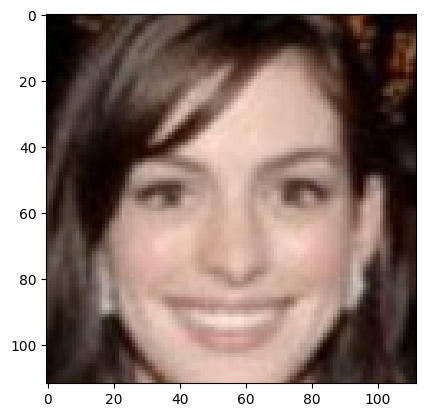

torch.Size([3, 112, 112]) tensor(1) tensor(15)


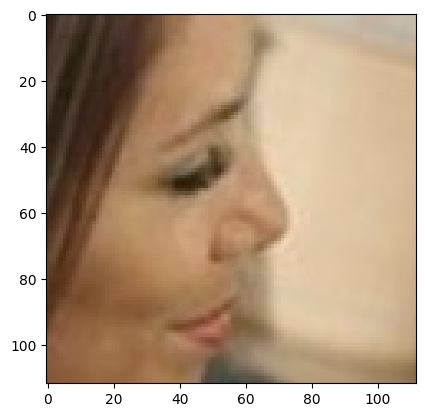

torch.Size([3, 112, 112]) tensor(3) tensor(38)


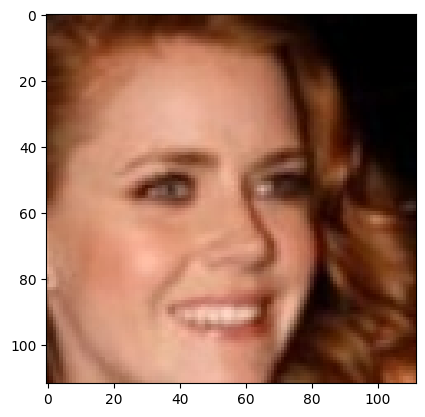

torch.Size([3, 112, 112]) tensor(9) tensor(93)


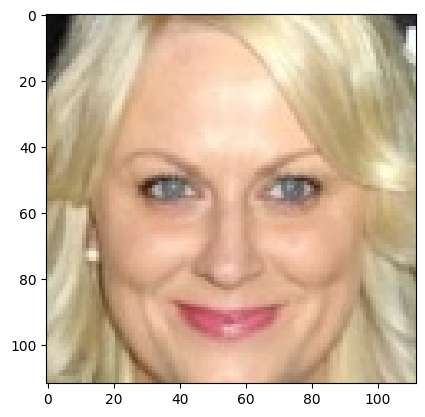

torch.Size([3, 112, 112]) tensor(1) tensor(13)


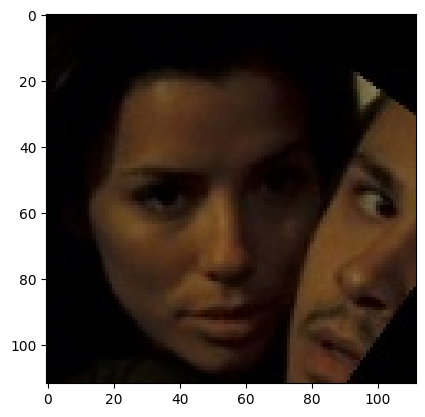

torch.Size([3, 112, 112]) tensor(4) tensor(42)


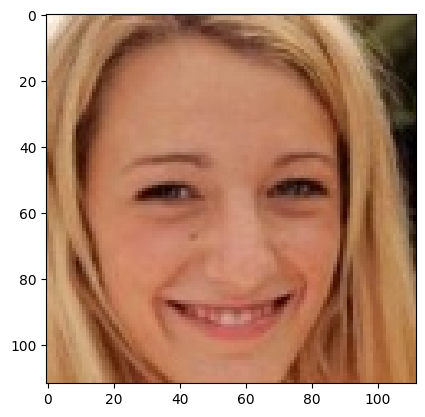

torch.Size([3, 112, 112]) tensor(7) tensor(76)


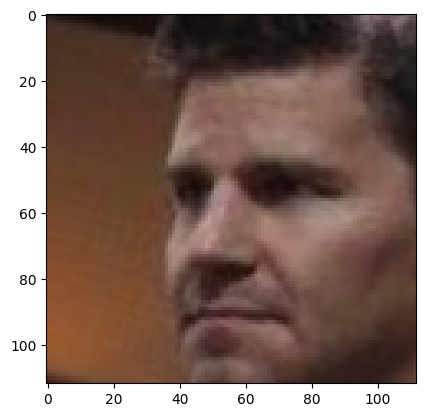

torch.Size([3, 112, 112]) tensor(4) tensor(44)


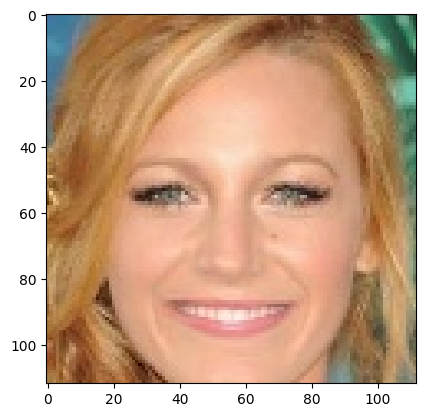

torch.Size([3, 112, 112]) tensor(0) tensor(3)


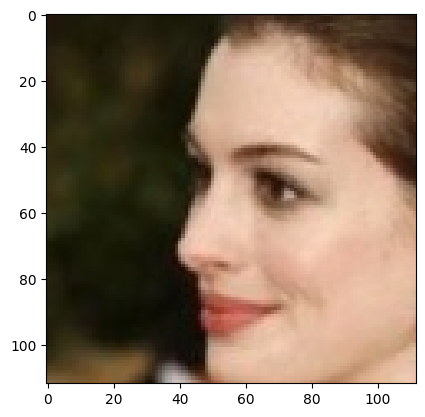

torch.Size([3, 112, 112]) tensor(3) tensor(39)


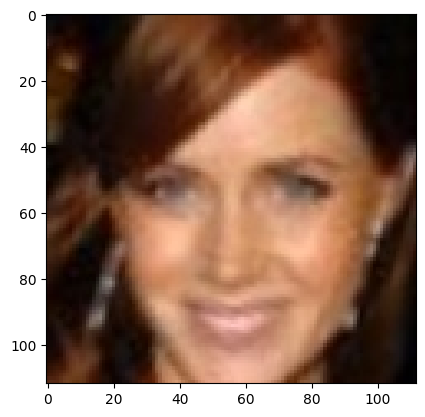

In [20]:
inverse_normalize = transforms.Compose([
    transforms.Normalize(mean = [0., 0., 0.], std = [1/0.5, 1/0.5, 1/0.5]),
    transforms.Normalize(mean = [-0.5, -0.5, -0.5], std = [1., 1., 1.]), 
])

for batch_idx, (x,y,z) in enumerate(dl):
    if batch_idx > 0:
        break
    for i in range(len(x)):
        if i > 10:
            break
        fig, ax = plt.subplots()
        print(x[i].shape, y[i], z[i])
        # show 100 images from first batch using pyplot
        ax.imshow(torch.clip(inverse_normalize(x[i].squeeze()).permute(1, 2, 0), 0, 1))
        plt.show()


In [78]:
class TracIn:
    def __init__(self, header: nn.Module, criterion: nn.Module, checkpoints: List[str], dl: DataLoader):
        self.header = header
        self.criterion = criterion

        self.headers = []
        self.fc_layers = []
        self.layers_except_fc = []
        for cp in checkpoints:
            backbone.load_state_dict(torch.load(cp))
            backbone.eval()

            self.fc_layers.append(nn.Sequential(*list(backbone.children())[-2:]))
            self.layers_except_fc.append(nn.Sequential(*list(backbone.children())[:-2]))

            self.header.load_state_dict(torch.load(cp.replace('backbone', 'header')))
            self.header.eval()
            self.headers.append(header)

        self.loss_grads = []
        self.activations = []
        self.labels = []
        self.image_ids = []
        self.predictions = []

    def compute_loss_grads(self):
        for samples, labels, indices in dl:
            samples = samples.to(device)
            labels = labels.to(device)

            batch_activations = []
            batch_loss_grads = []

            for layers, fc_layer, header in zip(self.layers_except_fc, self.fc_layers, self.headers):
                # print("layers except fc: ", layers)
                # print("fc: ", fc_layer.shape)
                # print("header: ", header.shape)
                h = layers(samples)
                print(h.shape)
                logits = fc_layer(h)
                outputs = header(logits)
                probs = self.criterion(outputs, labels)
                loss_grad = torch.nn.functional.one_hot(labels, num_classes=CASIA_NUM_CLASSES, device=device) - probs
                batch_activations.append(h.detach())
                batch_loss_grads.append(loss_grad.detach())

            
            self.image_ids.extend(indices.cpu().numpy())
            self.labels.extend(labels.cpu().numpy())
            self.activations.append(batch_activations)
            self.loss_grads.append(batch_loss_grads)
        

    def influence(self):
        """
        Calculate the influence of each sample in the dataset. Returns a matrix of influence scores where the element at (i, j) represents the influence of sample j on sample i.
        Returns:
            influence_matrix (np.ndarray): A matrix of influence scores.
        """
        influence_matrix = np.zeros((len(self.image_ids), len(self.image_ids)), dtype=np.float32)
        self.compute_loss_grads()

        print(self.activations)

        for i, (activation, loss_grad) in enumerate(zip(self.activations, self.loss_grads)):
            break
        
        return influence_matrix

In [79]:
def run_checkpoint_calculation():
    """
    Calculate the contributions of a set of samples checkpoint-wise.

    Returns:
        influence_scores (Tensor): Influence scores as a 2D tensor of shape (num_samples, num_samples), where influence_scores[i][j] indicates the influence of sample j on sample i.
        labels (list): List of labels corresponding to the samples.
        indices (list): List of indices corresponding to the samples.
    """
    checkpoint_paths = [CHECKPOINTS_PATH_FORMAT.format(i * 4790) for i in range(1, 5)]  # use every tenth epoch as a checkpoint to evaluate

    tracin = TracIn(
        header=header,
        criterion=criterion,
        checkpoints=checkpoint_paths,
        dl=dl
    )

    print("Processing checkpoint 0")
    self_infl_scores, labels, indices = tracin.influence()

    for idx, path in enumerate(checkpoint_paths[1:]):
        print(f"Processing checkpoint {idx + 1} at {path}")
        if not os.path.exists(path):
            print(f"Checkpoint {path} does not exist, skipping.")
            continue
        
        new_self_infl_scores, _, _ = checkpoint_contribution(dl, path)
        self_infl_scores += new_self_infl_scores

    return self_infl_scores, labels, indices

In [80]:
def main():
    print("start influence calculation")
    self_influence_scores, labels, indices = run_checkpoint_calculation()

    influence_scores_np = self_influence_scores.cpu().numpy()

    influence_scores_df = pd.DataFrame(influence_scores_np, columns=indices[0].numpy(), index=indices[0].numpy())
    
    influence_scores_df.to_csv('output/influence_scores.csv', index=True, header=True, sep=';')

In [81]:
if __name__ == "__main__":
    main()

start influence calculation
[Linear(in_features=25088, out_features=512, bias=True), BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
[Linear(in_features=25088, out_features=512, bias=True), BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
[Linear(in_features=25088, out_features=512, bias=True), BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
[Linear(in_features=25088, out_features=512, bias=True), BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Processing checkpoint 0
torch.Size([10, 512, 7, 7])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (35840x7 and 25088x512)